In [2]:
from dataclasses import dataclass
from enum import Enum, auto
from typing import Self
from uuid import uuid4
from bamt.preprocessors import Preprocessor
import pandas as pd
from sklearn import preprocessing as pp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import re
from bamt.networks import HybridBN
import random
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from tqdm import tqdm
import seaborn as sns


YEAR = 2022

In [3]:
df = pd.read_csv(

    "/Users/pishchulov/edu/matobes/НИР/outer_source/migration/ITMO-2/migforecasting/mig whereabouts/inflow LO.csv")

Выделим ОКТМО из Ленобласти

In [4]:
oktmos = map(str,  df.oktmo.unique())

In [5]:
oktmos_lo = [x for x in oktmos if re.fullmatch(r"41\d+", x)]

In [6]:
del oktmos

In [7]:
len(oktmos_lo)

226

Определим численность населения. Проблема: удалось найти данные только за 2024 год

In [8]:
pop_size_df = pd.read_excel(

    "/Users/pishchulov/edu/matobes/НИР/outer_source/численность МО/Сhisl_MO_01-01-2024_only_LO.xlsx")

In [9]:
pop_size_df

,Коды территорий,Unnamed: 1,население,городское,сельское
0,4100000000,Ленинградская область,2035762,1373533,662229
1,41754000 0 0,Сосновоборский городской округ,63462,63462,0
2,41754000001 1 0 0 0,г Сосновый Бор,63462,63462,0
3,41603000 0 0,Бокситогорский муниципальный район,50855,39107,11748
4,41603101 0 0,Городское поселение Бокситогорское,15764,15480,284
...,...,...,...,...,...
271,41648418 0 0,Сельское поселение Нурминское,3338,0,3338
272,41648430 0 0,Сельское поселение Лисинское,1875,0,1875
273,41648443 0 0,Сельское поселение Тельмановское,26781,0,26781
274,41648444 0 0,Сельское поселение Трубникоборское,1599,0,1599


In [10]:
def discard_to_8_chars(s):
    if len(s) != 10:
        return s
    if s[-2:] == "00":
        return s[:-2]

In [11]:
pop_size_df["Коды территорий"] = pd.Series([discard_to_8_chars(x.replace(

    " ", "")) for x in map(str, pop_size_df["Коды территорий"])], dtype=str)

In [12]:
# pop_size_df_lo = pop_size_df[pop_size_df["Коды территорий"].isin(oktmos_lo)]

In [13]:
# set(oktmos_lo) - set(pop_size_df_lo["Коды территорий"])

Проблема: некоторые ОКТМО исчезли, потому что они эти населенные пункту переехали на новые коды. Проигнорируем.

In [14]:
del pop_size_df

In [15]:
# pop_size_df_lo=pop_size_df_lo.drop(["городское", "сельское"], axis = 1)
# pop_size_df_lo=pop_size_df_lo.set_axis(["oktmo", "name", "pop_size"], axis=1)
# pop_size_df_lo.sort_values("oktmo", inplace=True)
# pop_size_df_lo

Удалим муниципальные районы, потому что это агрегаты других МО

In [16]:
def is_mun_district(oktmo):
    assert len(oktmo) == 8
    return oktmo[-3:] == "000"

In [17]:
# pop_size_df_lo.pop_size.sum()

In [18]:
# mun_districts_lo = pop_size_df_lo[pop_size_df_lo.oktmo.apply(is_mun_district)]
# mun_districts_lo

In [19]:
# pop_size_df_lo=pop_size_df_lo[~pop_size_df_lo.oktmo.apply(is_mun_district)]
# pop_size_df_lo.pop_size.sum()

### Подготовим данные о среде. 

In [20]:
allmun = pd.read_csv(

    "/Users/pishchulov/edu/matobes/НИР/outer_source/rosstat_allmun/allmuns/popsize (allmun).csv")
allmun[["oktmo"]] = allmun[["oktmo"]].astype(str)
allmun["from_lo"] = [bool(re.fullmatch(r"41\d+", x)) for x in allmun.oktmo]
allmun = allmun[(allmun.from_lo) & (allmun.year == YEAR)]
allmun = allmun[["oktmo", "name", "year", "popsize"]].set_index("oktmo")
allmun["popsize"] = allmun["popsize"].astype(int)

In [21]:
allmun

,name,year,popsize
oktmo,,,
41603000,Бокситогорский муниципальный район,2022,47236
41603101,Бокситогорское,2022,14606
41603102,Пикалёвское,2022,19250
41603155,Ефимовское,2022,4389
41603412,Большедворское,2022,1486
...,...,...,...
41648430,Лисинское,2022,1703
41648443,Тельмановское,2022,13191
41648444,Трубникоборское,2022,1479


Нет ITMO2 данных за 2023 год, поэтому используем 2022.

In [22]:

mo_features = allmun
# files = [
#     "shoparea",
#     "foodseats",
#     "agrprod",
#     "beforeschool",
#     "schoolnum",  # тут нет требуемых районов
#     "museums",
#     "theatres",
#     "musartschool",
#     "hospitalcap",
#     "pollutionvol",
#     "popsize",
#     "retailturnover",
#     "livarea",

# ]
files = """parks
schoolnum
cliniccap
sportsvenue
consnewareas
popsize
livestock
saldo internat
consnewapt
budincome
musartschool
foodservturnover
goodcompanies
invest
factoriescap
shoparea
museums
agrprod
roadslen
hospitals
outflow
foodseats
servicesnum
avgsalary
harvest
funds
library
cultureorg
saldo interreg
avgemployers
naturesecure
goodcompincome
visiblecompanies
retailturnover
beforeschool
theatres
saldo reg
docsnum
livarea
badcompanies""".split('\n')

files_about_mo = ["sportsvenue", "invest",

                  "popsize", "shoparea", "roadslen", "hospitals"]
for f in files:
    d = pd.read_csv(
        f"/Users/pishchulov/edu/matobes/НИР/outer_source/migration/ITMO-2/migforecasting/superdataset/features separately/{f} (allmun).csv")
    d[["oktmo"]] = d[["oktmo"]].astype(str)
    d["from_lo"] = [bool(re.fullmatch(r"41\d+", x)) for x in d.oktmo]
    d_lo = d[(d.from_lo) 
            #  & (d.year == 2022)
             ]
    if len(d_lo):
        print(f" f== {f} {len(d_lo)}")
    # d = d[(d.oktmo.isin(mo_features.index)) & (
    #     d.year == 2022)].drop(["from_lo"], axis=1)
    # if len(d) == 0:
    #     print(f"error in {f}")
    # else:
    #     mo_features = mo_features.join(d.set_index("oktmo").iloc[:, -1:], )

 f== parks 184
 f== schoolnum 2515
 f== cliniccap 998
 f== sportsvenue 3583
 f== consnewareas 2662
 f== popsize 2621
 f== livestock 288
 f== saldo internat 2246
 f== consnewapt 72
 f== budincome 3260
 f== musartschool 950
 f== foodservturnover 153
 f== goodcompanies 1432
 f== invest 2912
 f== factoriescap 162
 f== shoparea 3003
 f== museums 482
 f== agrprod 270
 f== roadslen 2467
 f== hospitals 1754
 f== outflow 2508
 f== foodseats 2710
 f== servicesnum 3062
 f== avgsalary 417
 f== harvest 273
 f== funds 2777
 f== library 1816
 f== cultureorg 2502
 f== saldo interreg 2508
 f== avgemployers 417
 f== naturesecure 374
 f== goodcompincome 902
 f== visiblecompanies 1695
 f== retailturnover 234
 f== beforeschool 1412
 f== theatres 74
 f== saldo reg 2503
 f== docsnum 1003
 f== livarea 396
 f== badcompanies 1022


In [23]:
mun_districts = mo_features[pd.Series(
    mo_features.index, index=mo_features.index).apply(is_mun_district)]["name"]
mun_districts

oktmo
41603000     Бокситогорский муниципальный район
41606000        Волосовский муниципальный район
41609000         Волховский муниципальный район
41612000       Всеволожский муниципальный район
41615000         Выборгский муниципальный район
41618000         Гатчинский муниципальный район
41621000      Кингисеппский муниципальный район
41624000          Киришский муниципальный район
41625000          Кировский муниципальный район
41627000    Лодейнопольский муниципальный район
41630000      Ломоносовский муниципальный район
41633000            Лужский муниципальный район
41636000       Подпорожский муниципальный район
41639000        Приозерский муниципальный район
41642000        Сланцевский муниципальный район
41645000         Тихвинский муниципальный район
41648000         Тосненский муниципальный район
41754000                         Сосновоборский
Name: name, dtype: object

#### Список муниципальных образований без муниципальных округов

In [24]:
mun_units = mo_features[~pd.Series(
    mo_features.index, index=mo_features.index).apply(is_mun_district)][["name", "popsize"]]

In [25]:
len(mo_features), len(mun_units)

(205, 187)

# Генерация популяции

Распределения по полу и возрасту есть только для муниципальных районов.
migration/ITMO-2/popsize/data0.xlsx

In [26]:
@dataclass
class AgeGroup:
    lo: int
    hi: int

    def __str__(self):
        return f"{self.lo}-{self.hi}"

    @staticmethod
    def from_str(s):
        lo, hi = list(map(int, s.split('-')))
        return AgeGroup(lo=lo, hi=hi)

    def get_random_age(self):
        return random.choice(list(range(self.lo, self.hi+1)))


age_groups = [
    AgeGroup(0, 0),
    AgeGroup(1, 4),
    AgeGroup(5, 9),
    AgeGroup(10, 14),
    AgeGroup(15, 19),
    AgeGroup(20, 24),
    AgeGroup(25, 29),
    AgeGroup(30, 34),
    AgeGroup(35, 39),
    AgeGroup(40, 44),
    AgeGroup(45, 49),
    AgeGroup(50, 54),
    AgeGroup(55, 59),
    AgeGroup(60, 64),
    AgeGroup(65, 69),
    AgeGroup(70, 74),
    AgeGroup(75, 79),
    AgeGroup(80, 84),
    AgeGroup(85, 89),
    AgeGroup(90, 94),
    AgeGroup(95, 99),
    AgeGroup(100, 100),
]
gender_age_dist_by_district_oktmo = {}
for mun_district_oktmo, mun_district_name_series in pd.DataFrame(mun_districts).iterrows():
    mun_district_name = mun_district_name_series.iloc[0]
    mun_district_first_name = mun_district_name.split()[0]
    try:
        df = pd.read_excel(

            "/Users/pishchulov/edu/matobes/НИР/outer_source/migration/ITMO-2/popsize/data0.xlsx", sheet_name=mun_district_first_name)
    except ValueError:
        df = pd.read_excel(

            "/Users/pishchulov/edu/matobes/НИР/outer_source/migration/ITMO-2/popsize/data0.xlsx", sheet_name=mun_district_first_name+" ")

    col_num = list(df.iloc[0, :]).index(YEAR)
    year_data = df.iloc[:, col_num]
    males = []
    females = []
    for i, ag in enumerate(age_groups):
        female = year_data.iloc[6+i*4]
        male = year_data.iloc[7+i*4]
        males.append(male)
        females.append(female)

    gender_age_dist = pd.DataFrame(
        {"male": males, "female": females}, index=list(map(str, age_groups)))
    gender_age_dist = gender_age_dist.fillna(gender_age_dist.mean())
    gender_age_dist_by_district_oktmo[mun_district_oktmo] = gender_age_dist

##### Построим набор данных, следующих имеющемуся распредление пола и возраста

In [27]:
def gender_age_dist_to_population(gender_age_dist_by_district_oktmo):
    """Принимает распределение по полу и возрасту для каждого мун. района.
    Генереириует популяцию.
    Разворачивает статистики в выборку, 
    предполагая, что в каждой возрастной группе возраст распредлен равномерно"""
    age_sex_population = []
    for district_oktmo, age_sed_distribution_df in gender_age_dist_by_district_oktmo.items():
        for age_group_str, row in age_sed_distribution_df.iterrows():
            age_group = AgeGroup.from_str(age_group_str)
            males_cnt = int(row["male"])
            females_cnt = int(row["female"])
            for _ in range(males_cnt):
                age_sex_population.append(
                    (age_group.get_random_age(), 1, district_oktmo))
            for _ in range(females_cnt):
                age_sex_population.append(
                    (age_group.get_random_age(), 0, district_oktmo))
    population = pd.DataFrame(age_sex_population, columns=[
        "age", "male", "district_oktmo"]).sample(frac=1).reset_index(drop=True)
    return population

Популяция по мун. районам

In [28]:
population = gender_age_dist_to_population(gender_age_dist_by_district_oktmo)
mun_district_population = population
population

,age,male,district_oktmo
0,73,0,41606000
1,21,0,41618000
2,23,0,41621000
3,25,0,41642000
4,24,1,41648000
...,...,...,...
2074072,75,1,41642000
2074073,56,1,41615000
2074074,53,1,41625000
2074075,20,1,41612000


### Определим образование. Построим условное распределение образования от пола и возраста.

In [29]:
rlms = pd.read_excel("/Users/pishchulov/edu/matobes/НИР/Data_RLMS.xlsx")
data = rlms[["age", "male", "educ", "lnwage", "children"]]

#### Обучим классифкатор для предсказания уровня образования на данных RLMS

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    
    data[["age", "male"]], data['educ'], test_size=.2)
educ_clsf = XGBClassifier()
educ_clsf.fit(X_train, y_train) 
preds = educ_clsf.predict(X_test)  # TODO predict proba
# accuracy == 40% - на первый взгляд довольно плохой результат,
# но все равно гораздо лучше, чем назначать уровень образования исходя из общих рассуждений и здравого смысла
accuracy_score(y_test, preds)

0.42838709677419357

#### Применим классификатор, чтобы назначить уровень образования для агентов из популяции

In [31]:
population["educ"] =educ_clsf.predict(population[["age", "male"]])

In [32]:
population

,age,male,district_oktmo,educ
0,73,0,41606000,2
1,21,0,41618000,2
2,23,0,41621000,3
3,25,0,41642000,3
4,24,1,41648000,2
...,...,...,...,...
2074072,75,1,41642000,1
2074073,56,1,41615000,1
2074074,53,1,41625000,1
2074075,20,1,41612000,2


### Определим зарплату. Построим зависимость от пола, возраста и образования

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    
    data[["age", "male", "educ"]], data['lnwage'], test_size=.2)
wage_regressor = XGBRegressor()
wage_regressor.fit(X_train, y_train)
preds = wage_regressor.predict(X_test)
mape(y_test, preds)  # mape == 0.05 - отличный результат.

0.05777846826696446

In [34]:
population["lnwage"] = wage_regressor.predict(
    
    population[["age", "male", "educ"]])

### Определим количество детей

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data[["age", "male", "educ", "lnwage"]], data["children"],
                                                    test_size=.2)
children_regressor = XGBRegressor()
children_regressor.fit(X_train, y_train)
preds = children_regressor.predict(X_test).round()
mae(y_test, preds)

0.6503225806451612

In [36]:
population["children"] = children_regressor.predict(
    
    population[["age", "male", "educ", "lnwage"]]).round().astype(int)

In [37]:

data["male"] = rlms.male.astype(str)
data["educ"] = rlms.educ.astype(str)

# set encoder and discretizer
encoder = pp.LabelEncoder()
discretizer = pp.KBinsDiscretizer(
    
    n_bins=5, encode="ordinal", strategy="uniform")

# create preprocessor object with encoder and discretizer
p = Preprocessor([("encoder", encoder), ("discretizer", discretizer)])

# discretize data for structure learning
discretized_data, est = p.apply(data)

# get information about data
info = p.info

# initialize network object
bn = HybridBN(use_mixture=True, has_logit=True)

# add nodes to network
bn.add_nodes(info)

# using mutual information as scoring function for structure learning
bn.add_edges(
    discretized_data,
    #  scoring_function=('MI',)
)

# or use evolutionary algorithm to learn structure

bn.add_edges(discretized_data)

bn.fit_parameters(data)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [38]:
# bn.save("pop.json")
bn.plot('mixture.html')
bn.validate(info)

True

In [39]:
sampled_data = bn.sample(10_000, progress_bar=False)
# sampled_data.children = sampled_data.children.astype(int)
sampled_data.male = sampled_data.male.astype(int)
sampled_data.age = sampled_data.age.astype(int)

In [40]:
sampled_data

,lnwage,children,male,educ,age
0,8.642592,3,0,3,33
1,9.715212,2,0,1,47
2,9.111921,1,0,1,46
3,10.017518,0,1,3,32
4,9.321067,0,1,2,36
...,...,...,...,...,...
9995,7.702775,1,0,1,44
9996,9.118553,1,1,1,30
9997,10.267792,1,0,2,40
9998,10.149878,2,1,2,41


# Сгенерирруем популяцию для каждого МО из Ленобласти

In [41]:
def to_district_oktmo(oktmo):
    assert len(oktmo) == 8
    return oktmo[:5]+"000"

In [42]:
from functools import cache



def get_mun_unit_population(mun_units, mun_district_population):
    mun_unit_population = pd.DataFrame(columns=["age", "male", "oktmo"])
    for mun_unit in tqdm(list(mun_units.reset_index().itertuples(index=False))):
        district_oktmo = to_district_oktmo(mun_unit.oktmo)
        pop    = (mun_district_population[mun_district_population.district_oktmo == district_oktmo]
               .sample(mun_unit.popsize)[["age", "male"]])
        pop["oktmo"] = mun_unit.oktmo
        pop = pd.DataFrame(pop, columns=["age", "male", "oktmo"])
        mun_unit_population = pd.concat([mun_unit_population, pop])
    mun_unit_population["age"] = mun_unit_population["age"].astype(int)
    mun_unit_population["male"] = mun_unit_population["male"].astype(int)
    mun_unit_population["oktmo"] = mun_unit_population["oktmo"].astype(str)
    return mun_unit_population


    

mun_unit_population = get_mun_unit_population(
    mun_units, mun_district_population)

100%|██████████| 187/187 [00:18<00:00,  9.93it/s]


In [43]:
mun_unit_population

,age,male,oktmo
750374,40,1,41603101
1924262,45,1,41603101
173548,16,1,41603101
1452877,37,1,41603101
879174,52,1,41603101
...,...,...,...
1945741,27,0,41648464
1977803,27,1,41648464
1071166,93,1,41648464
1737379,55,0,41648464


### Определим образование, зарплату, количество детей для популяции

In [44]:
mun_unit_population["educ"] = educ_clsf.predict(
    
    mun_unit_population[["age", "male"]])
    
mun_unit_population["lnwage"] = wage_regressor.predict(
        mun_unit_population[["age", "male", "educ"]])
mun_unit_population["children"] = children_regressor.predict(
    mun_unit_population[["age", "male", "educ", "lnwage"]]).round().astype(int)

In [62]:
mun_unit_population # TODO указать конкретные возраста детей. если до 6 лет, то вероятность миграци поменяется

,age,male,oktmo,educ,lnwage,children
750374,40,1,41603101,1,10.046045,1
1924262,45,1,41603101,1,10.062603,2
173548,16,1,41603101,0,9.464142,0
1452877,37,1,41603101,3,10.860463,2
879174,52,1,41603101,1,10.049314,2
...,...,...,...,...,...,...
1945741,27,0,41648464,1,9.285212,2
1977803,27,1,41648464,3,10.184039,1
1071166,93,1,41648464,1,9.601593,1
1737379,55,0,41648464,2,9.464200,2


In [45]:
mun_units

,name,popsize
oktmo,,
41603101,Бокситогорское,14606
41603102,Пикалёвское,19250
41603155,Ефимовское,4389
41603412,Большедворское,1486
41603416,Борское,3272
...,...,...
41648418,Нурминское,2977
41648430,Лисинское,1703
41648443,Тельмановское,13191


In [46]:
inflow = pd.read_csv(
    "/Users/pishchulov/edu/matobes/НИР/outer_source/migration/ITMO-2/migforecasting/superdataset/mig data/total/inflow/inflow 2022 (allmun).csv")
outflow = pd.read_csv(
    "/Users/pishchulov/edu/matobes/НИР/outer_source/migration/ITMO-2/migforecasting/superdataset/mig data/total/outflow/outflow 2022 (allmun).csv")
inflow['oktmo'] = inflow['oktmo'].astype(str)
outflow['oktmo'] = outflow['oktmo'].astype(str)
inflow = inflow[inflow.oktmo.isin(mun_units.index)]
inflow = inflow.set_index("oktmo")[["inflow"]].astype(int)
outflow = outflow[outflow.oktmo.isin(mun_units.index)]
outflow = outflow.set_index("oktmo")[["outflow"]].astype(int)

mun_units = mun_units.join(inflow).join(outflow)
mun_units["saldo"] = mun_units.inflow - mun_units.outflow

In [47]:
mun_units.sort_values("saldo").tail(50)

,name,popsize,inflow,outflow,saldo
oktmo,,,,,
41603476,Самойловское,2096,188,155,33
41639424,Ларионовское,2578,206,172,34
41621432,Кузёмкинское,1336,86,46,40
41603460,Лидское,2137,144,102,42
41639420,Красноозёрное,1105,86,44,42
41609108,Сясьстройское,12644,314,271,43
41642101,Сланцевское,32833,1449,1405,44
41618418,Войсковицкое,6217,231,181,50
41606420,Калитинское,6478,357,307,50


## Степенное распредление числа жителей в МО

In [48]:
import numpy as np
from scipy.stats import powerlaw
from scipy.optimize import minimize
import matplotlib.pyplot as plt

a = 0.8
loc = 3
scale = 10
bins = 100

In [49]:
# def example_fit():
#     fig, ax = plt.subplots(1, 1)
#     np.linspace(powerlaw.ppf(0.01, a, loc=loc, scale=scale),
#                     powerlaw.ppf(0.999, a, loc=loc, scale=scale), 1000)
#     ax.plot(x, powerlaw.pdf(x, a),
#             'r-', lw=5, alpha=0.6, label='powerlaw pdf')
#         powerlaw(a, loc=loc, scale=scale)
#     ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
#         powerlaw.rvs(a, loc =loc, scale=scale, size=1000)
#         ist(r, density=True, bins=bins, histtype='stepfilled', alpha=0.2)
#     ax.set_xlim([x[0], x[-1]])
#     ax.legend(loc='best', frameon=False)
#     params = powerlaw.fit(r, method="MLE",)
#     t, loc_fit, scale_fit = params
#     t = powerlaw(a_fit, loc_fit, scale_fit).pdf(x)
#     ax.plot(x, y_fit,
#         'r-', lw=5, alpha=0.6, label='powerlaw pdf', color="green")
#     plt.show()




# example_fit()

In [50]:
ps = mun_units.popsize.sort_values()

(0.2995730938561535, 438.99999999999994, 90132.00000000001)


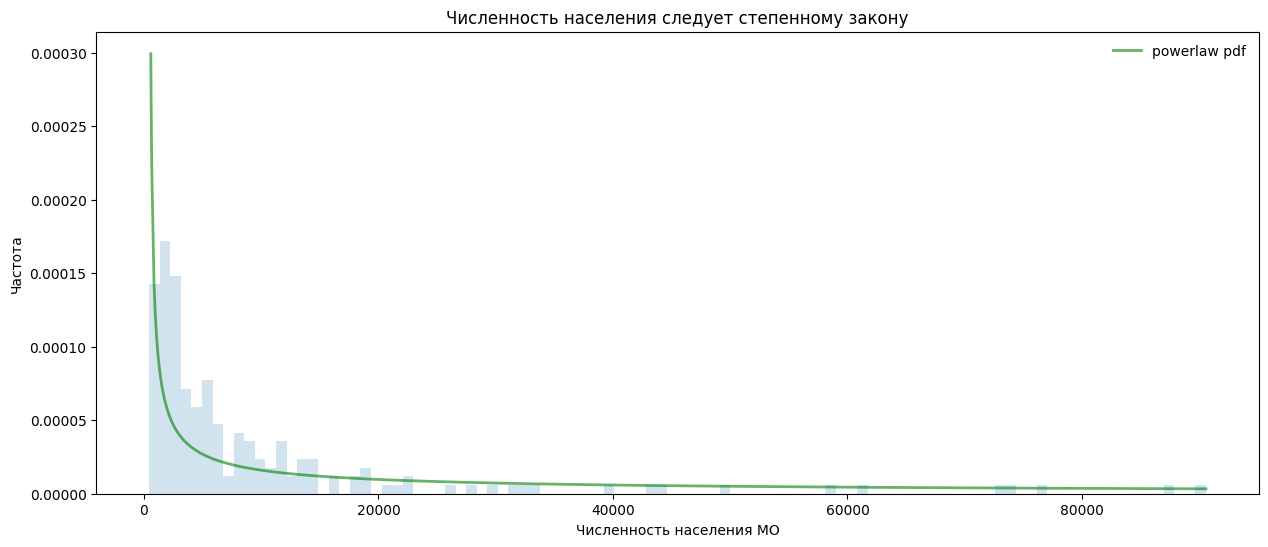

In [51]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(15)
params = powerlaw.fit(ps, method="MLE",)
a_fit, loc_fit, scale_fit = params
print(params)
y_fit = powerlaw(a_fit, loc_fit, scale_fit).pdf(ps)
ax.hist(ps, density=True, bins=bins, histtype='stepfilled', alpha=0.2, 
        label = "")
ax.plot(ps[2:], y_fit[2:],
        'r-', lw=2, alpha=0.6, label='powerlaw pdf', color="green")

ax.legend(loc='best', frameon=False)
plt.xlabel('Численность населения МО')
plt.ylabel('Частота')
plt.title("Численность населения следует степенному закону")
plt.show()

In [52]:
sd = pd.read_csv(
    
    "/Users/pishchulov/edu/matobes/НИР/outer_source/migration/ITMO-2/migforecasting/superdataset/superdataset (full data).csv")
sd["oktmo"] = sd["oktmo"].astype(str)
sd["year"] = sd["year"].astype(str)
sd = sd[sd.oktmo.isin(mun_units.index)]

In [53]:
# mun_units.sort_values("popsize", ascending=False).head(50)

#### Гипотеза: в больших городах доля приезжающих (уезжающих) больше

In [54]:
mun_units["saldo_rel"] = mun_units.saldo  / mun_units.popsize
mun_units["in_and_out_flow"] = mun_units.inflow + mun_units.outflow


In [55]:
df = mun_units.sort_values("popsize", ascending=False)
# df["inflow_rel"] = df.inflow/df.popsize
# df["outflow_rel"] = df.outflow/df.popsize
# df = df.drop(["inflow", "outflow"], axis=1)
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df.popsize,
        y=df.saldo,
    )
)

<Axes: >

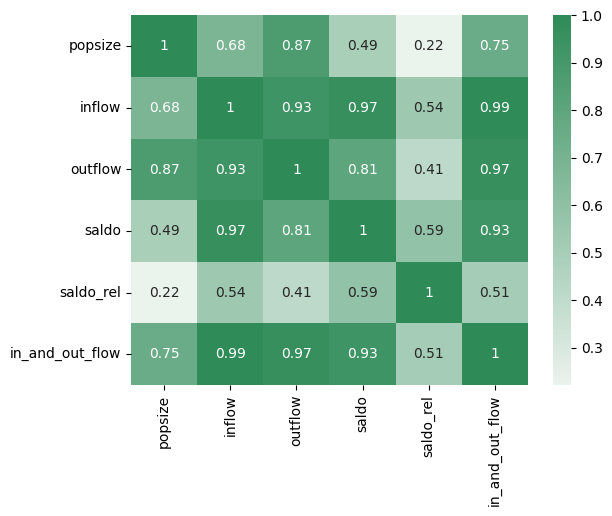

In [56]:
corr = df.drop("name", axis=1).corr()
sns.heatmap(corr,  annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap=sns.light_palette("seagreen", as_cmap=True))

In [57]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df.popsize,
        y=df.inflow,
    )
)

Число миграционных взаимодействий in_and_out_flow коррелирует с численностью населения.

Можно построить граф, в котором узел - город, ребро - переезд между городами.

Следует ли in_and_out_flow степенному закону?

(0.2100683069241509, 32.99999999999999, 27332.000000000004)


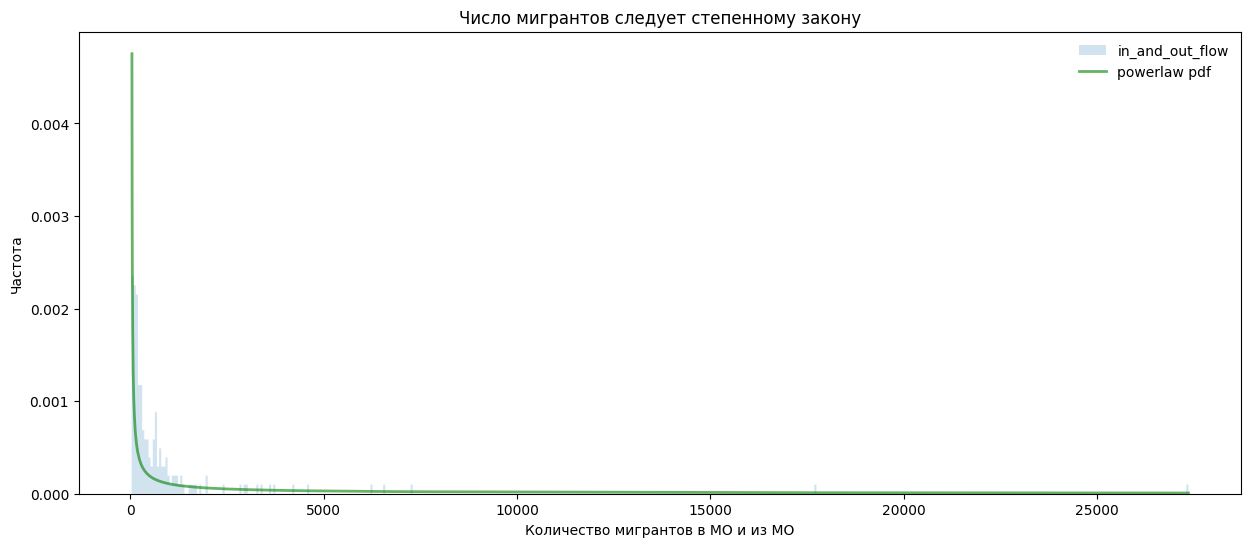

In [58]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(15)
mun_units = mun_units.sort_values("in_and_out_flow")
in_and_out_flow = mun_units.in_and_out_flow
params = powerlaw.fit(in_and_out_flow, method="MLE",)
a_fit, loc_fit, scale_fit = params
print(params)
y_fit = powerlaw(a_fit, loc_fit, scale_fit).pdf(in_and_out_flow)
y_hist, x, _ =ax.hist(in_and_out_flow, density=True, bins=500, histtype='stepfilled', alpha=0.2,
                      label = "in_and_out_flow")
ax.plot(in_and_out_flow[1:], y_fit[1:],
        'r-', lw=2, alpha=0.6, label='powerlaw pdf', color="green")
ax.legend(loc='best', frameon=False)
plt.xlabel('Количество мигрантов в МО и из МО')
plt.ylabel('Частота')
plt.title("Число мигрантов следует степенному закону")
plt.show()

#### Характеристики муниципальных районов (9 шт.)

In [59]:
df = pd.read_csv("/Users/pishchulov/edu/matobes/НИР/outer_source/migration/ITMO-2/migforecasting/clustering/datasets/superdataset-24 alltime-clust (oktmo).csv")
df["oktmo"] = df.oktmo.astype(str)

In [60]:
mun_distrcits_lo = [x for x in df.oktmo if re.fullmatch(r"41\d+", x)]
# df[df.oktmo.isin(mun_distrcits_lo)]

# Модель

In [63]:
mun_unit_population

,age,male,oktmo,educ,lnwage,children
750374,40,1,41603101,1,10.046045,1
1924262,45,1,41603101,1,10.062603,2
173548,16,1,41603101,0,9.464142,0
1452877,37,1,41603101,3,10.860463,2
879174,52,1,41603101,1,10.049314,2
...,...,...,...,...,...,...
1945741,27,0,41648464,1,9.285212,2
1977803,27,1,41648464,3,10.184039,1
1071166,93,1,41648464,1,9.601593,1
1737379,55,0,41648464,2,9.464200,2


### pull-факторы

In [70]:
age_distance_conditional_distribution = pd.DataFrame({
    "0-14": [9.9, 29.8, 12.3, 12.0, 11.5, 8.2, 14.5, 1.8],
    "16-16": [3.7, 28, 22.2, 17.9, 12.2,  5.7, 9.2, 1.1],
    "18-18": [2.2, 13.2, 16, 20.7, 19.7, 10.9, 15.9, 1.4],
    "15-19": [3.4, 19.0, 17.7, 19.0, 16.5, 9, 14, 1.4],
    "20-24": [5.0, 17.5, 12.7, 15.1, 16.1, 11.1, 20.3, 2.2],
    "25-49": [8, 23.2, 11.3, 12.3, 13.4, 10.5, 19, 2.3],
    "50-64": [9.2, 24.7, 10.3, 10.3, 11.4, 9.3, 21.6, 3.2],
    "65-100": [8.3, 25.4, 12.5, 12.4, 12.8, 9.1, 17, 2.5]
}, index = ["1-10", "10-50","50-100", "100-200", "200-500", "500-1000", "1000-5000", "5000-10000"])
# источник - https://journals.kantiana.ru/upload/iblock/a91/1_4-22.pdf    doi: 10.5922/2079-8555-2023-2-1
age_distance_conditional_distribution

,0-14,16-16,18-18,15-19,20-24,25-49,50-64,65-100
1-10,9.9,3.7,2.2,3.4,5.0,8.0,9.2,8.3
10-50,29.8,28.0,13.2,19.0,17.5,23.2,24.7,25.4
50-100,12.3,22.2,16.0,17.7,12.7,11.3,10.3,12.5
100-200,12.0,17.9,20.7,19.0,15.1,12.3,10.3,12.4
200-500,11.5,12.2,19.7,16.5,16.1,13.4,11.4,12.8
500-1000,8.2,5.7,10.9,9.0,11.1,10.5,9.3,9.1
1000-5000,14.5,9.2,15.9,14.0,20.3,19.0,21.6,17.0
5000-10000,1.8,1.1,1.4,1.4,2.2,2.3,3.2,2.5


In [74]:
# Признаки: age	 male	oktmo	educ	lnwage	children
def p_mo_size(agent, target_mo_pop_size, k):
    """Реализует правило 'В большом городе ожидаем большой приток населения' 
    target_mo_pop_size - численность населения города, в который рассматривается переезд
    k - коэффициент важности этого pull-фактора"""

    return target_mo_pop_size * k


def p_conditional_distribution_age_and_distance(agent, distance):
    distrib = None
    for age_group_str in age_distance_conditional_distribution.columns:
        lo, hi = list(map(int, age_group_str.split('-')))
        
        if lo<= agent.age <=hi:
            distrib = age_distance_conditional_distribution[age_group_str]
            break 
    for dist_option in distrib.index:
        lo, hi = list(map(int, dist_option.split('-'))) 
        if lo<=distance<=hi:
            return distrib[dist_option]
    raise ValueError(f"Can not find distance option. {agent}")
    
    
p_conditional_distribution_age_and_distance(mun_unit_population.iloc[4], 500)
            

11.4